# Importing Libraries

Source: https://www.kaggle.com/code/nuhashafnan/bangla-sentiment-analysis-cnn-lstm-hybrid-network

In [23]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import LabelEncoder

!pip install unidecode
!pip install openpyxl

import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold



In [24]:
dataset_cricket = pd.read_excel(io="Cricket.xlsx", sheet_name="Sheet1", engine='openpyxl')
dataset_cricket.head()

,Source,Date,Text,Category,Polarity
0,BBC Bangla,2018-06-03 00:00:00,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,other,positive
1,BBC Bangla,2018-06-04 00:00:00,জয় বাংলা কাপ! তাও আবার স্বাধীনতার মাস মার্চে। ...,team,positive
2,BBC Bangla,15/6/2017,বাংলাদেশের পরে ভারতের সাপর্ট ই করি ?,team,positive
3,BBC Bangla,15/6/2020,সৌম্যকে বাদ দেওয়া হোক,batting,negative
4,BBC Bangla,27/1/2018,"প্রথমটি হচ্ছে, কোচ অত:পর সাকিব,সাকিব আর সাকিবর...",team,positive


C:\Users\joyan\.conda\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Polarity', ylabel='count'>

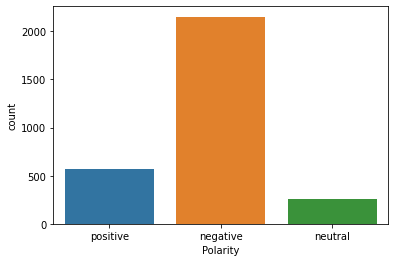

In [25]:
sns.countplot(dataset_cricket['Polarity'])

In [26]:
dataset_restaurant = pd.read_excel(io="Restaurant.xlsx", sheet_name="Sheet1", engine='openpyxl')
dataset_restaurant.head()

,SL,Text,Category,Polarity
0,0,"স্টাফ কিন্তু, আমাদের জন্য ভয়ঙ্কর ছিল।",service,negative
1,1,"শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...",food,positive
2,2,"শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...",anecdotes/miscellaneous,negative
3,3,"খাবার একদমই ব্যতিক্রমী, একটি খুব সক্ষম রান্নাঘ...",food,positive
4,4,যেখানে গাব্রিয়েলা লোকালি আপনাকে শুভেচ্ছা জানা...,service,positive


C:\Users\joyan\.conda\envs\tf_gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Polarity', ylabel='count'>

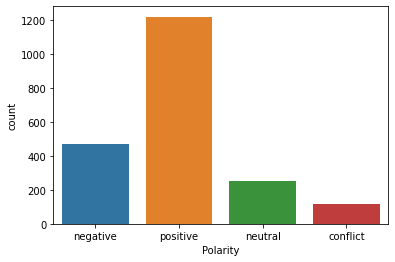

In [27]:
sns.countplot(dataset_restaurant['Polarity'])

4 polarities in Restaurant Dataset

# Data Preprocessing

In [28]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [29]:
dataset_restaurant['Text'] = dataset_restaurant.Text.apply(lambda x: preprocessing(str(x)))
dataset_cricket['Text'] = dataset_cricket.Text.apply(lambda x: preprocessing(str(x)))

In [30]:
dataset_cricket.reset_index(drop=True, inplace=True)
dataset_restaurant.reset_index(drop=True, inplace=True)

In [31]:
enc = LabelEncoder()
dataset_cricket['Polarity'] = enc.fit_transform(dataset_cricket['Polarity'])
dataset_restaurant['Polarity'] = enc.fit_transform(dataset_restaurant['Polarity'])

Now I will prepare the dataset to train in the CNN LSTM network.So i have to convert all Sentences into a numpy Array.

I have divided the training and testing data into 80/20 ratio.

I have converted the sentiment values into one hot encodings for the convenient use in model training.

In [32]:
train1, test1 = train_test_split(dataset_cricket,random_state=69, test_size=0.2)
training_sentences_cricket = []
testing_sentences_cricket = []



train_sentences_cricket=train1['Text'].values
train_labels_cricket=train1['Polarity'].values
for i in range(train_sentences_cricket.shape[0]): 
    #print(train_sentences[i])
    x=str(train_sentences_cricket[i])
    training_sentences_cricket.append(x)
    
training_sentences_cricket=np.array(training_sentences_cricket)





test_sentences_cricket=test1['Text'].values
test_labels_cricket=test1['Polarity'].values

for i in range(test_sentences_cricket.shape[0]): 
    x=str(test_sentences_cricket[i])
    testing_sentences_cricket.append(x)
    
testing_sentences_cricket=np.array(testing_sentences_cricket)


train_labels_cricket=tf.keras.utils.to_categorical(train_labels_cricket)


test_labels_cricket=tf.keras.utils.to_categorical(test_labels_cricket)
print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(training_sentences_cricket.shape))
print("testing_sentences shape: "+str(testing_sentences_cricket.shape))
print("train_labels shape: "+str(train_labels_cricket.shape))
print("test_labels shape: "+str(test_labels_cricket.shape))

Training Set Length: 2383
Testing Set Length: 596
training_sentences shape: (2383,)
testing_sentences shape: (596,)
train_labels shape: (2383, 3)
test_labels shape: (596, 3)


In [33]:
print(training_sentences_cricket[1])
print(train_labels_cricket[0])

নবাগত প্লেয়ার হয়েও চাপের মুখে দলের বিপদে চমৎকার একটি  রানের ইনিংস খেলেছেন লিটন
[1. 0. 0.]


Now i will predefine some variables.

vocab_size is the maximum vocabulary length of Tokenizer.

KERAS tokenzier allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...

I will be tokenizing my dataset with this class here.I have did this tokenization so that it can be later used to generate Embeddings.

The main advantage of word embedding is that words that share a similar context can be represented close to each other in the vector space. Thus, vectors carry a sense of semantic of a word.

I have predefined the embedding dimension as 300(embedding_dim).

max_length is the sentence maximum length.

trunc_type is the truncation type.

oov_token is the token for the words that are not present in the corpus.oov means out of vocabulary.

In [34]:
vocab_size = len(training_sentences_cricket)+1
embedding_dim = 100
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"

In [35]:
print(training_sentences_cricket.shape)
print(train_labels_cricket.shape)

(2383,)
(2383, 3)


At first i will tokenize and then i will be padding the sequences.I have used tokenizer only on training dataset to see how the model performs on unseen words.

In [36]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences_cricket)
word_index = tokenizer.word_index
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(training_sentences_cricket)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(testing_sentences_cricket)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

6414
Word index length:6414


In [37]:
print("Sentence :--> \n")
print(training_sentences_cricket[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

তারা কোথায় যারা বলেছিল হাতুরাসিংহে বনাম বাংলাদেশ এর খেলা

Sentence Tokenized and Converted into Sequence :--> 

[70, 1514, 141, 859, 1, 460, 4, 19, 23]

After Padding the Sequence with padding length 100 :--> 

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0   70 1514  141  859    1  460    4
   19   23]


In [38]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (2383, 100)
Padded shape(testing): (596, 100)


# Model Creation

At first i have created embeddings from the text.

In first layer,i created an conv1D with 200 as filter for CNN.

In second & third layer,i have applied two Bi-LSTM with a dropout of .5.

In rest of the layer i have applied Dense network.

I have used Adap Optimizer with fine tuned hyperparameters.

I have also applied L2 regularizations to reduce overfitting as much as possible.

In [39]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    pr = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    f1_score = 2 * (pr * rec) / (pr + rec)
    return f1_score

In [40]:
# with tf.device('/gpu:0'):
#     model= Sequential()
#     model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
#     model.add(Conv1D(50, kernel_size=3, activation = "relu"))
#     model.add(Dropout(0.3))
#     model.add(Conv1D(100, kernel_size=3, activation = "relu"))
#     # model.add(Bidirectional(LSTM(64, return_sequences=True)))
#     model.add(Dropout(0.3))
#     # model.add(Bidirectional(LSTM(64)))
#     # model.add(Dense(50, activation='relu'))
#     model.add(Dense(50, activation='relu'))
#     model.add(Flatten())
#     #l2 regularizer
#     model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
#     model.add(Dense(3, activation='softmax'))
#     #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
#     adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
#     model.summary()
#     model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

In [41]:
# from tensorflow.keras.layers import GlobalMaxPooling1D

detection=Sequential()

detection.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

#1 -convolutional layer-1
# detection.add(Conv1D(64 ,kernel_size=3))
# detection.add(BatchNormalization())
# detection.add(Activation('relu'))
# detection.add(GlobalMaxPooling1D())

#2 -convolutional layer-2
detection.add(Conv1D(96,kernel_size=3))
detection.add(BatchNormalization())
detection.add(Activation('relu'))
# detection.add(GlobalMaxPooling1D())

#2 -convolutional layer-2
detection.add(Conv1D(128,kernel_size=3))
detection.add(BatchNormalization())
detection.add(Activation('relu'))
# detection.add(GlobalMaxPooling1D())
detection.add(Dropout(0.2))


#2 -convolutional layer-2
detection.add(Conv1D(256,kernel_size=3))
detection.add(BatchNormalization())
detection.add(Activation('relu'))
# detection.add(MaxPooling2D(pool_size=(2,2)))
# detection.add(GlobalMaxPooling1D())
detection.add(Dropout(0.2))

#3 -convolutional layer-3
detection.add(Conv1D(384,kernel_size=3))
detection.add(BatchNormalization())
detection.add(Activation('relu'))
# detection.add(GlobalMaxPooling1D())
# detection.add(MaxPooling2D(pool_size=(2,2)))
# detection.add(UpSampling2D(input_shape=(512, 3, 3)))
detection.add(Dropout(0.2))

#3 -convolutional layer-3
detection.add(Conv1D(512,kernel_size=3))
detection.add(BatchNormalization())
detection.add(Activation('relu'))
# detection.add(GlobalMaxPooling1D())
# detection.add(MaxPooling2D(pool_size=(2,2)))
# detection.add(UpSampling2D(input_shape=(512, 3, 3)))
detection.add(Dropout(0.3))


detection.add(Flatten())
detection.add(Dense(512))
detection.add(BatchNormalization())
detection.add(Activation('relu'))

detection.add(Flatten())
detection.add(Dense(256))
detection.add(BatchNormalization())
detection.add(Activation('relu'))

detection.add(Flatten())
detection.add(Dense(128))
detection.add(BatchNormalization())
detection.add(Activation('relu'))

detection.add(Flatten())
detection.add(Dense(64))
detection.add(BatchNormalization())
detection.add(Activation('relu'))

detection.add(Dense(3,activation='sigmoid'))
optimum=Adam(lr=0.0001)
detection.summary()
detection.compile(optimizer=optimum,loss='binary_crossentropy',metrics=['accuracy', precision, recall,  f1_score])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          238400    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 98, 96)            28896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 98, 96)            384       
_________________________________________________________________
activation_9 (Activation)    (None, 98, 96)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 96, 128)           36992     
_________________________________________________________________
batch_normalization_10 (Batc (None, 96, 128)           512       
_________________________________________________________________
activation_10 (Activation)   (None, 96, 128)          

In [42]:
model_cricket=detection.fit(padded,train_labels_cricket,shuffle=True,epochs=10,batch_size=16,validation_data=(testing_padded,test_labels_cricket),use_multiprocessing=True, workers=8)

Train on 2383 samples, validate on 596 samples
Epoch 1/10
2383/2383 [==============================] - 6s 2ms/sample - loss: 0.7582 - accuracy: 0.4988 - precision: 0.3529 - recall: 0.5891 - f1_score: 0.4400 - val_loss: 0.6838 - val_accuracy: 0.6717 - val_precision: 0.2500 - val_recall: 0.0181 - val_f1_score: nan
Epoch 2/10
2383/2383 [==============================] - 3s 1ms/sample - loss: 0.6079 - accuracy: 0.6889 - precision: 0.5418 - recall: 0.6462 - f1_score: 0.5844 - val_loss: 0.6119 - val_accuracy: 0.6667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: nan
Epoch 3/10
2383/2383 [==============================] - 3s 1ms/sample - loss: 0.5227 - accuracy: 0.7937 - precision: 0.6993 - recall: 0.6773 - f1_score: 0.6864 - val_loss: 0.5947 - val_accuracy: 0.7097 - val_precision: 0.8295 - val_recall: 0.1612 - val_f1_score: nan
Epoch 4/10
2383/2383 [==============================] - 3s 1ms/sample - loss: 0.4852 - accuracy: 0.8133 - precision: 0.7290 - recall: 0.7037 - f

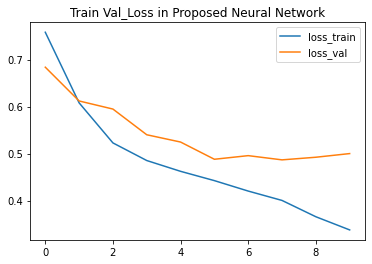

In [43]:
plt.plot(model_cricket.history['loss'], label='loss_train')
plt.plot(model_cricket.history['val_loss'], label='loss_val')
# plt.plot(mod.history['accuracy'], label='acc_train')
# plt.plot(mod.history['val_accuracy'], label='acc_val')
plt.legend()
plt.title('Train Val_Loss in Proposed Neural Network')
plt.show()
# plt.savefig('LossVal_loss_nonaugmented')

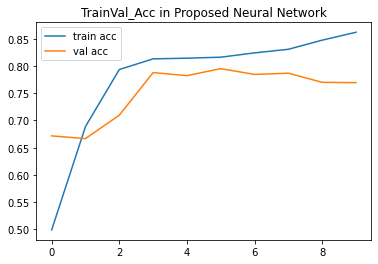

In [44]:
plt.plot(model_cricket.history['accuracy'], label='train acc')
plt.plot(model_cricket.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('TrainVal_Acc in Proposed Neural Network')
plt.show()
# plt.savefig('AccVal_acc_nonaugmented')